In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import os

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

from torchvision.transforms import transforms
from torchvision import models

from sklearn.metrics import roc_auc_score

np.random.seed(252525)
torch.manual_seed(252525)

from meanshift import *

device = "cuda"

In [ ]:
log = []
p = 1
n = 100000

for netname in ["vitb16", "raw", "eff", "res", "vgg"], 
    
    s = 4 if netname == "vitb16" else 2
    L = 7 if netname == "vitb16" else 5
    blocks = [L, L+1] if netname == "vgg" or  netname == "eff" else [L]
    
    for P in [16, 24, 30, 32]:
    
        for A in [32]:
            
            if P > A:
                continue

            r = int( (A - P)/s + 1 )

            for run in range(3):
                
                if netname != "raw":
                    net, layer_map = get_fmap(netname)
                    net = net.to(device)
                    net = net.eval()


                for clazz in range(0, 10):
                    
                    if netname == "raw":
                        X, X_valid, X_test = Cifar10_OneClass(train_classes=[clazz], balance=False, fold=run, download=False)[0]
                        X, X_valid, X_test,  mean, std = preprocess(X, X_valid, X_test)
                    else:
                        transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                        ])
                        X, X_valid, X_test = Cifar10_OneClass(train_classes=[clazz], balance=False, fold=run, download=False)[0]
                    
                    X, X_valid, X_test = asreshape(X, X_valid, X_test, shape=(3, 32, 32))
                        
                    if netname == "raw":
                        net, layer_map = get_pca(X, 0.9, P, s)
                        net = net.to(device)
                        net = net.eval()

                    if netname == "vitb16":
                        X = patches_to_feature_space_vit(X, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                        X_valid = patches_to_feature_space_vit(X_valid, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                        X_test = patches_to_feature_space_vit(X_test, net, P=P, s=s, blocks=blocks, layer_map=layer_map)
                    else:
                        X = patches_to_feature_space(X, net, P, s, blocks=blocks, layer_map=layer_map, debug=True)
                        X_valid = patches_to_feature_space(X_valid, net, P, s, blocks=blocks, layer_map=layer_map)
                        X_test = patches_to_feature_space(X_test, net, P, s, blocks=blocks, layer_map=layer_map)

                    print(X.shape)

                    mu, means, cov, T = estimate_statistics(X[np.random.permutation(len(X))][:n], mode="ledoit", BSZ=(p, p), rho=r)
                    s_in = local_hotelling(X_valid, T, mu, means, cov, BSZ=(p, p), rho=r)
                    s_out = local_hotelling(X_test, T, mu, means, cov, BSZ=(p, p), rho=r)

                    auc_local = roc_auc_score([0] * len(X_valid) + [1] * len(X_test), np.concatenate([s_in, s_out]))

                    log.append(pd.DataFrame(np.asarray([run, netname, clazz, Cifar10_OneClass.CLASSES[clazz], A, P, s, p, blocks[0], n, r, auc_local])[:, None].T, columns=["run", "fmap", "class", "class_name", "A", "P", "s", "BSZ", "layers", "n_samples", "rho", "auc_local"])) 

                    display(log[-1])
                    
                    torch.save(log, "backup_vitb16.log")

(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,0,plane,32,16,4,1,7,100000,5,0.825743


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,1,car,32,16,4,1,7,100000,5,0.840677


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,2,bird,32,16,4,1,7,100000,5,0.7173450000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,3,cat,32,16,4,1,7,100000,5,0.83554


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,4,deer,32,16,4,1,7,100000,5,0.8744909999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,5,dog,32,16,4,1,7,100000,5,0.8231729999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,6,frog,32,16,4,1,7,100000,5,0.893332


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,7,horse,32,16,4,1,7,100000,5,0.8820899999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,8,ship,32,16,4,1,7,100000,5,0.8795879999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,0,vitb16,9,truck,32,16,4,1,7,100000,5,0.909755


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,0,plane,32,16,4,1,7,100000,5,0.8038129999999999


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,1,car,32,16,4,1,7,100000,5,0.862067


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,2,bird,32,16,4,1,7,100000,5,0.720294


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,3,cat,32,16,4,1,7,100000,5,0.82159


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,4,deer,32,16,4,1,7,100000,5,0.866139


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,5,dog,32,16,4,1,7,100000,5,0.821898


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,6,frog,32,16,4,1,7,100000,5,0.896529


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,7,horse,32,16,4,1,7,100000,5,0.852662


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,8,ship,32,16,4,1,7,100000,5,0.8812839999999998


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,1,vitb16,9,truck,32,16,4,1,7,100000,5,0.920236


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,0,plane,32,16,4,1,7,100000,5,0.81575


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,1,car,32,16,4,1,7,100000,5,0.864905


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,2,bird,32,16,4,1,7,100000,5,0.7308950000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,3,cat,32,16,4,1,7,100000,5,0.8124790000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,4,deer,32,16,4,1,7,100000,5,0.866769


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,5,dog,32,16,4,1,7,100000,5,0.8246770000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,6,frog,32,16,4,1,7,100000,5,0.896389


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,7,horse,32,16,4,1,7,100000,5,0.869531


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,8,ship,32,16,4,1,7,100000,5,0.8899520000000001


(5000, 768, 5, 5)


,run,fmap,class,class_name,A,P,s,BSZ,layers,n_samples,rho,auc_local
0,2,vitb16,9,truck,32,16,4,1,7,100000,5,0.913044


[0.00874878 0.00920694 0.0059282  0.01429822 0.0110238 ]
[0.00304606 0.00107685 0.00250522 0.00404679 0.00235279]
[0.00204103 0.00261188 0.01380233 0.00429114 0.01490386]
[0.00809003 0.00137268 0.01955289 0.00687233 0.02241   ]
[0.0021144  0.00060649 0.00645228 0.00648379 0.00123077]


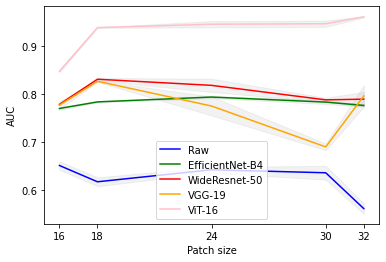

In [15]:
import tikzplotlib

names = ["Raw", "EfficientNet-B4", "WideResnet-50", "VGG-19", "ViT-16"] 
colors = ["b", "g", "r", "orange", "pink"]
dat = pd.concat(torch.load("experiments/cifar10_patchsize.log"))

for i, netname in enumerate(dat["fmap"].unique()):
    x = dat[dat["fmap"] == netname][["run", "class", "auc_local", "P"]].astype(np.float32).groupby("P").mean().index
    y = dat[dat["fmap"] == netname][["run", "class", "auc_local", "P"]].astype(np.float32).groupby("P").mean()["auc_local"]
    s = dat[dat["fmap"] == netname][["run", "class", "auc_local", "P"]].astype(np.float32).groupby(["run", "P"]).mean().groupby([ "P"]).std()["auc_local"]
    
    x, y, s = np.asarray(x), np.asarray(y), np.asarray(s)
    print(s)
    plt.plot(x, y, label=names[i], color=colors[i])
    plt.fill_between(x, y-s, y+s, color="grey", alpha=.1)

plt.xticks(x)
plt.ylabel("AUC")
plt.xlabel("Patch size")
plt.title("")
plt.legend()
tikzplotlib.save("tex/CIFAR10-Patchsize.tex")